In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import datetime
import tensorflow as tf
from tensorflow import keras

In [12]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [13]:
#  Traitement des valeurs manquantes
# Remplacement des valeurs manquantes
cat_cols = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
for col in cat_cols:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    test_df[col].fillna(test_df[col].mode()[0], inplace=True)
    
    
num_cols = ['Weight Capacity (kg)']
for col in num_cols:
    train_df[col].fillna(train_df[col].median(), inplace=True)
    test_df[col].fillna(test_df[col].median(), inplace=True)



/var/folders/yc/172r56sn5v1bsbrx7_7qsctw0000gn/T/ipykernel_24802/2004934186.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mode()[0], inplace=True)
/var/folders/yc/172r56sn5v1bsbrx7_7qsctw0000gn/T/ipykernel_24802/2004934186.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [14]:
# Encodage des variables catégoriques
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Encoder chaque colonne catégorique séparément et remplacer dans le DataFrame original
for col in cat_cols:
    # Fit et transform sur les données d'entrainement
    encoded_train = encoder.fit_transform(train_df[[col]])
    encoded_test = encoder.transform(test_df[[col]])
    
    # Remplacer la colonne originale par la version encodée
    train_df[col] = encoded_train
    test_df[col] = encoded_test



In [15]:
# Séparation des features et de la cible
X = train_df.drop(columns=['Price', 'id'])
y = train_df['Price']


In [16]:
# Split en train et validation (80% - 20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [17]:
def model_relu_linear(X_train_scaled, y_train, X_val_scaled, y_val):
    # Configuration de TensorBoard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    
    # Construction du modèle
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[X_train_scaled.shape[1]]),  
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1, activation="linear")
    ])
    
    # Compilation du modèle
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=[keras.metrics.RootMeanSquaredError()]
    )
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True
    )
    
    # Entraînement avec TensorBoard
    history = model.fit(
        X_train_scaled, 
        y_train,
        epochs=50,
        batch_size=128,
        validation_data=(X_val_scaled, y_val),
        verbose=1,
        callbacks=[early_stopping, tensorboard_callback]
    )
    
    # Évaluation du modèle
    train_rmse = model.evaluate(X_train_scaled, y_train, verbose=0)[1]
    val_rmse = model.evaluate(X_val_scaled, y_val, verbose=0)[1]
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    
    # Visualisation avec matplotlib
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, max(history.history["loss"]))
    plt.show()
    
    return model, history


Epoch 1/50


/opt/anaconda3/envs/dlenv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 2582.7375 - root_mean_squared_error: 49.6453 - val_loss: 1535.6011 - val_root_mean_squared_error: 39.1867
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 1562.1151 - root_mean_squared_error: 39.5235 - val_loss: 1532.8717 - val_root_mean_squared_error: 39.1519
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 1563.1860 - root_mean_squared_error: 39.5371 - val_loss: 1568.5020 - val_root_mean_squared_error: 39.6043
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 1575.3582 - root_mean_squared_error: 39.6907 - val_loss: 1533.6708 - val_root_mean_squared_error: 39.1621
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 1585.1792 - root_mean_squared_error: 39.8136 - val_loss: 1766.6989 - val_root_mean_squared_error: 42.0321
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 1627.0802 - root_mean_squared_error: 40.3363 - val_loss: 1527.4452 - val_root_mean_squared_error:

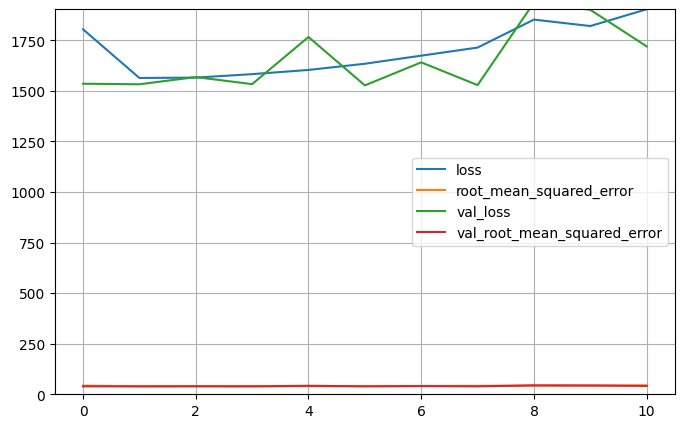

In [19]:
model, history = model_relu_linear(X_train_scaled, y_train, X_val_scaled, y_val)

In [16]:
# model.py
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Preprocess data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# XGBoost model with optimized parameters
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Create ensemble
def ensemble_predict(models, X):
    predictions = np.column_stack([
        model.predict(X) for model in models
    ])
    return np.mean(predictions, axis=1)

# Train models
xgb_model.fit(X_scaled, y)
rf_model.fit(X_scaled, y)

# Make predictions using ensemble
models = [xgb_model, rf_model]
predictions = ensemble_predict(models, X_scaled)

# Evaluate using cross-validation
cv_scores = cross_val_score(xgb_model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -cv_scores


In [17]:
print(f"Cross-validation RMSE: {rmse_scores.mean():.4f} +/- {rmse_scores.std():.4f}")

Cross-validation RMSE: 39.0375 +/- 0.0932


In [10]:
def generate_kaggle_submission(model, test_df, scaler):
    """
    Generate predictions on test data and create Kaggle submission file with unique timestamp
    """
    # Create unique filename with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    submission_path = f'submission_{timestamp}.csv'
    
    # Prepare test data
    X_test = test_df.drop(columns=['id'])
    
    # Scale test data using the same scaler
    X_test_scaled = scaler.transform(X_test)
    
    # Generate predictions
    predictions = model.predict(X_test_scaled)
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'Price': predictions.flatten()
    })
    
    # Round predictions to 2 decimal places
    submission_df['Price'] = submission_df['Price'].round(2)
    
    # Save to CSV with unique filename
    submission_df.to_csv(submission_path, index=False)
    print(f"Submission file created: {submission_path}")
    
    # Display first few rows
    print("\nFirst few predictions:")
    print(submission_df.head())
    
    return submission_df, submission_path

# Test the model and generate submission
submission, filepath = generate_kaggle_submission(model, test_df, scaler)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Submission file created: submission_20250225_123420.csv

First few predictions:
       id      Price
0  300000  83.879997
1  300001  87.489998
2  300002  81.730003
3  300003  80.040001
4  300004  78.070000


/opt/anaconda3/envs/dlenv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 7630.3750 - root_mean_squared_error: 87.3427 - val_loss: 6050.4238 - val_root_mean_squared_error: 77.7845
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 5764.3584 - root_mean_squared_error: 75.8920 - val_loss: 3828.2344 - val_root_mean_squared_error: 61.8727
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 3518.3369 - root_mean_squared_error: 59.2629 - val_loss: 2162.8218 - val_root_mean_squared_error: 46.5061
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 2065.2200 - root_mean_squared_error: 45.4285 - val_loss: 1590.9512 - val_root_mean_squared_error: 39.8867
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1643.9500 - root_mean_squared_error: 40.5453 - val_loss: 1524.4927 - val_root_mean_squared_error: 39.0448
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1597.0916 - root_mean_squared_error: 39.9635 - val_loss: 1522.5586 - val_root_mean_squared_error: 39.02

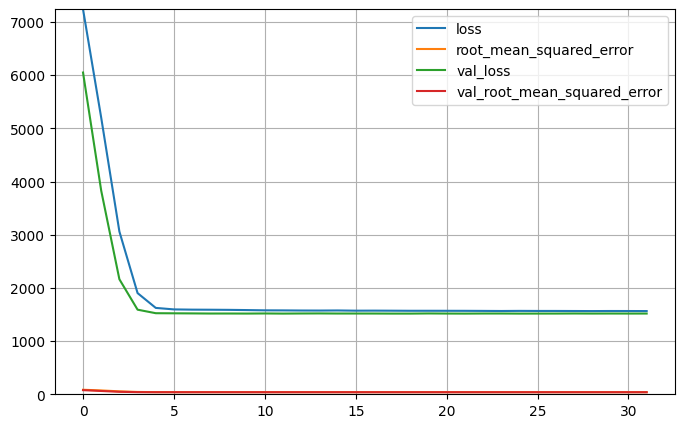

In [30]:
def improved_neural_network(X_train_scaled, y_train, X_val_scaled, y_val):
    # Configuration de TensorBoard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )

    # Construction du modèle amélioré
    model = keras.models.Sequential([
        keras.layers.Dense(512, kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        
        keras.layers.Dense(256, kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        
        keras.layers.Dense(128, kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        
        keras.layers.Dense(64, kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),

        keras.layers.Dropout(0.2),  # Ajout d'un Dropout pour éviter l'overfitting
        keras.layers.Dense(1, activation="linear")
    ])

    # Compilation du modèle
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    )

    # Entraînement du modèle
    history = model.fit(
        X_train_scaled, 
        y_train,
        epochs=50,
        batch_size=1024,
        validation_data=(X_val_scaled, y_val),
        verbose=1,
        callbacks=[early_stopping, tensorboard_callback]
    )

    # Évaluation du modèle
    train_rmse = model.evaluate(X_train_scaled, y_train, verbose=0)[1]
    val_rmse = model.evaluate(X_val_scaled, y_val, verbose=0)[1]
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")

    # Visualisation de la performance
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, max(history.history["loss"]))
    plt.show()

    return model, history

# Appel du modèle amélioré
model_improved, history_improved = improved_neural_network(X_train_scaled, y_train, X_val_scaled, y_val)

In [31]:
# Générer la soumission avec le modèle amélioré
submission_improved, filepath_improved = generate_kaggle_submission(model_improved, test_df, scaler)


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
Submission file created: submission_20250225_222405.csv

First few predictions:
       id      Price
0  300000  81.910004
1  300001  82.739998
2  300002  81.570000
3  300003  82.209999
4  300004  76.699997


In [ ]:
def cnn_model(X_train_scaled, y_train, X_val_scaled, y_val):
    """
    Convolutional Neural Network (CNN) for tabular data
    Optimized for MacBook M1 (8GB RAM)
    """

    # Reshape les données pour Conv1D (ajout d'une dimension)
    X_train_reshaped = X_train_scaled[..., np.newaxis]
    X_val_reshaped = X_val_scaled[..., np.newaxis]

    # Configuration de TensorBoard
    log_dir = "logs/cnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Construction du modèle CNN 1D
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", input_shape=(X_train_reshaped.shape[1], 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(pool_size=2),

        keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(pool_size=2),

        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="linear")  
    ])

    # Compilation du modèle
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    )

    # Entraînement du modèle CNN 1D
    history = model.fit(
        X_train_reshaped, 
        y_train,
        epochs=50,
        batch_size=512, 
        validation_data=(X_val_reshaped, y_val),
        verbose=1,
        callbacks=[early_stopping, tensorboard_callback]
    )

    # Évaluation du modèle
    train_rmse = model.evaluate(X_train_reshaped, y_train, verbose=0)[1]
    val_rmse = model.evaluate(X_val_reshaped, y_val, verbose=0)[1]
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")

    # Visualisation des performances
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, max(history.history["loss"]))
    plt.show()

    return model, history

# Appel du modèle CNN 1D
cnn_modelmode, history_cnn = cnn_model(X_train_scaled, y_train, X_val_scaled, y_val)

In [33]:
# Générer la soumission avec le modèle CNN 1D
submission_cnn, filepath_cnn = generate_kaggle_submission(model_cnn, test_df, scaler)


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Submission file created: submission_20250225_224913.csv

First few predictions:
       id      Price
0  300000  82.500000
1  300001  82.570000
2  300002  84.080002
3  300003  78.720001
4  300004  75.419998


/opt/anaconda3/envs/dlenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 122ms/step - loss: 10371.7656 - root_mean_squared_error: 101.5272 - val_loss: 4605.1904 - val_root_mean_squared_error: 67.8616
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - loss: 3944.9668 - root_mean_squared_error: 62.7734 - val_loss: 2771.4041 - val_root_mean_squared_error: 52.6441
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - loss: 2680.6062 - root_mean_squared_error: 51.7647 - val_loss: 2097.0085 - val_root_mean_squared_error: 45.7931
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - loss: 2134.4189 - root_mean_squared_error: 46.1973 - val_loss: 1799.2122 - val_root_mean_squared_error: 42.4171
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step - loss: 1939.0511 - root_mean_squared_error: 44.0335 - val_loss: 1690.3715 - val_root_mean_squared_error: 41.1141
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 1822.5533 - root_mean_squared_error: 42.6904 - val_loss: 1604.5765 - val_root_mean_squared

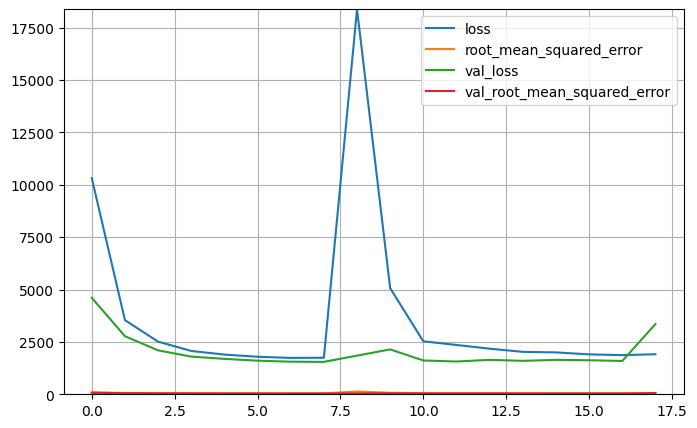

In [35]:
def rnn_model(X_train_scaled, y_train, X_val_scaled, y_val):
    """
    Recurrent Neural Network (RNN) using GRU for tabular data
    Optimized for MacBook M1 (8GB RAM)
    """

    # Reshape les données pour qu'elles aient une dimension temporelle (séquence)
    X_train_reshaped = X_train_scaled[..., np.newaxis]
    X_val_reshaped = X_val_scaled[..., np.newaxis]

    # Configuration de TensorBoard
    log_dir = "logs/rnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Construction du modèle RNN (GRU)
    model = keras.models.Sequential([
        keras.layers.GRU(64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
        keras.layers.BatchNormalization(),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.GRU(256),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="linear")  # Prédiction d'une valeur continue (Prix)
    ])

    # Compilation du modèle
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    )

    # Entraînement du modèle RNN
    history = model.fit(
        X_train_reshaped, 
        y_train,
        epochs=50,
        batch_size=1024,  # Réduction de batch_size pour économiser la RAM
        validation_data=(X_val_reshaped, y_val),
        verbose=1,
        callbacks=[early_stopping, tensorboard_callback]
    )

    # Évaluation du modèle
    train_rmse = model.evaluate(X_train_reshaped, y_train, verbose=0)[1]
    val_rmse = model.evaluate(X_val_reshaped, y_val, verbose=0)[1]
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")

    # Visualisation des performances
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, max(history.history["loss"]))
    plt.show()

    return model, history

# Appel du modèle RNN avec GRU
model_rnn, history_rnn = rnn_model(X_train_scaled, y_train, X_val_scaled, y_val)

In [36]:
# Générer la soumission avec le modèle RNN (GRU)
submission_rnn, filepath_rnn = generate_kaggle_submission(model_rnn, test_df, scaler)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step
Submission file created: submission_20250225_230322.csv

First few predictions:
       id      Price
0  300000  81.690002
1  300001  77.830002
2  300002  76.199997
3  300003  77.769997
4  300004  78.160004


In [38]:
def build_resnet_model(input_shape):
    """
    Implémentation d'un ResNet pour données tabulaires avec projections.
    Optimisé pour Mac M1 (8GB RAM).
    """
    
    inputs = keras.layers.Input(shape=(input_shape,))
    
    # Projection initiale
    x = keras.layers.Dense(256, activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)
    
    # Bloc Résiduel 1
    shortcut = x
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([shortcut, x])
    x = keras.layers.Activation("relu")(x)
    
    # Bloc Résiduel 2
    shortcut = keras.layers.Dense(128)(x)  # Projection pour correspondre à la nouvelle dimension
    shortcut = keras.layers.BatchNormalization()(shortcut)
    
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([shortcut, x])
    x = keras.layers.Activation("relu")(x)

    # Couche de sortie
    outputs = keras.layers.Dense(1, activation="linear")(x)

    # Construction du modèle
    model = keras.models.Model(inputs, outputs)

    # Compilation
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    return model

def train_resnet(X_train_scaled, y_train, X_val_scaled, y_val):
    """
    Entraînement du ResNet sur Mac M1 avec early stopping et TensorBoard.
    """
    
    # Configuration de TensorBoard
    log_dir = "logs/resnet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Création du modèle
    model = build_resnet_model(X_train_scaled.shape[1])

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    )

    # Entraînement
    history = model.fit(
        X_train_scaled, 
        y_train,
        epochs=10,
        batch_size=1024,  # Petite batch pour éviter surcharge RAM
        validation_data=(X_val_scaled, y_val),
        verbose=1,
        callbacks=[early_stopping, tensorboard_callback]
    )

    # Évaluation
    train_rmse = model.evaluate(X_train_scaled, y_train, verbose=0)[1]
    val_rmse = model.evaluate(X_val_scaled, y_val, verbose=0)[1]
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")

    return model, history

# Appel de l'entraînement
model_resnet, history_resnet = train_resnet(X_train_scaled, y_train, X_val_scaled, y_val)

# Tester le modèle ResNet sur les données de test
submission_resnet, filepath_resnet = generate_kaggle_submission(model_resnet, test_df, scaler)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 6456.7280 - root_mean_squared_error: 80.2497 - val_loss: 2883.1116 - val_root_mean_squared_error: 53.6946
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 2682.3652 - root_mean_squared_error: 51.6853 - val_loss: 1525.3175 - val_root_mean_squared_error: 39.0553
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 1561.5217 - root_mean_squared_error: 39.5157 - val_loss: 1526.3175 - val_root_mean_squared_error: 39.0681
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 1534.6327 - root_mean_squared_error: 39.1743 - val_loss: 1520.5955 - val_root_mean_squared_error: 38.9948
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1528.8864 - root_mean_squared_error: 39.1009 - val_loss: 1520.7657 - val_root_mean_squared_error: 38.9970
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1527.8026 - root_mean_squared_error: 39.0871 - val_loss: 1521.2650 - val_root_mean_squared_error: 